# 📈 Machine Learning for Algorithmic Trading with XGBoost & Technical Indicators

---

## 🎯 Project Overview

This notebook implements a **supervised machine learning pipeline** designed to predict **short-term price direction** of financial instruments using historical market data. The model leverages the powerful **XGBoost (eXtreme Gradient Boosting)** algorithm combined with a comprehensive suite of technical indicators to generate actionable trading signals.

### 🔑 Key Objectives

| Objective | Description |
|-----------|-------------|
| **Data Acquisition** | Download daily OHLCV (Open, High, Low, Close, Volume) data using `yfinance` API |
| **Feature Engineering** | Generate 40+ technical indicators across momentum, trend, volatility, and volume categories using `pandas_ta` |
| **Multi-Label Classification** | Create multiple labelling schemes with various look-ahead windows and threshold combinations |
| **Model Training & Evaluation** | Train XGBoost classifiers and evaluate performance across different label configurations |
| **Hyperparameter Optimization** | Fine-tune model parameters using TimeSeriesSplit cross-validation and GridSearchCV |
| **Model Interpretability** | Analyze feature importance using SHAP (SHapley Additive exPlanations) values |

### 📊 Classification Target

The model predicts three classes:
- **Class 0** → Neutral / No significant movement
- **Class 1** → Bearish / Sell signal (price expected to decline)
- **Class 2** → Bullish / Buy signal (price expected to rise)

### ⚠️ Important Disclaimer

> *This notebook is for educational and research purposes only. Trading financial instruments involves substantial risk, and past performance does not guarantee future results. Always conduct your own due diligence before making investment decisions.*

## 📦 Step 1: Environment Setup & Library Imports

---

### Required Dependencies

This section imports all necessary libraries for the ML pipeline:

| Library | Purpose |
|---------|---------|
| `yfinance` | Yahoo Finance API wrapper for downloading market data |
| `pandas` / `numpy` | Data manipulation and numerical computations |
| `pandas_ta` | Technical analysis library with 130+ indicators |
| `scikit-learn` | ML utilities: train/test split, cross-validation, metrics |
| `xgboost` | Gradient boosting framework for classification |
| `shap` | Model interpretability and feature importance analysis |
| `matplotlib` / `plotly` | Data visualization and interactive charts |

### 💡 Note
Make sure all packages are installed before running. You can install missing packages using:
```bash
pip install yfinance pandas pandas_ta scikit-learn xgboost shap matplotlib plotly tqdm
```

In [1]:

import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

pd.set_option("display.max_columns", None)


f:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 📥 Step 2: Historical Market Data Acquisition

---

### Data Source: Yahoo Finance

We utilize the `yfinance` library to download **daily OHLCV (Open, High, Low, Close, Volume)** data directly from Yahoo Finance servers.

### 📋 Data Fields Retrieved

| Field | Description |
|-------|-------------|
| **Open** | Opening price at market open |
| **High** | Highest price reached during the trading session |
| **Low** | Lowest price reached during the trading session |
| **Close** | Closing price at market close |
| **Volume** | Total number of shares/contracts traded |
| **Adj Close** | Adjusted close accounting for splits and dividends |

### 🎯 Supported Symbols

You can modify the `symbol` variable to analyze different instruments:
- **Indices**: `^GSPC` (S&P 500), `^DJI` (Dow Jones), `^IXIC` (NASDAQ)
- **Futures**: `ES=F` (E-mini S&P 500), `NQ=F` (E-mini NASDAQ)
- **Stocks**: `AAPL`, `MSFT`, `GOOGL`, etc.
- **ETFs**: `SPY`, `QQQ`, `IWM`, etc.

### ⏰ Time Range
The data is fetched from **January 1, 2010** to the current date, providing a substantial historical dataset for model training and validation.

In [2]:
#symbol = "^GSPC"
symbol = "ES=F"
start  = "2010-01-01"
end    = None

df = yf.download(symbol, start=start, end=end)

# flatten multi-level columns (this is for the recent yfinance versions)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.head()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10620\1034828366.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,1128.75,1129.75,1113.25,1113.75,1291254
2010-01-05,1132.25,1133.00,1125.00,1128.50,1378593
2010-01-06,1133.00,1135.50,1127.25,1132.00,1259921
2010-01-07,1137.50,1138.75,1127.00,1133.00,1567025
2010-01-08,1141.50,1141.75,1131.00,1137.25,1527666


## 🛠️ Step 3: Feature Engineering — Technical Indicators

---

### Why Technical Indicators?

Technical indicators are mathematical calculations based on price, volume, or open interest that traders use to forecast future price movements. By transforming raw OHLCV data into meaningful features, we provide the ML model with domain-specific knowledge.

### 📊 Indicator Categories

#### 1️⃣ **Momentum Indicators** — Measure the speed of price changes
| Indicator | Description | Parameters |
|-----------|-------------|------------|
| **RSI** | Relative Strength Index — oscillates between 0-100 | Lengths: 5, 10, 15 |
| **ROC** | Rate of Change — percentage change over N periods | Length: 10 |
| **MOM** | Momentum — absolute price change over N periods | Length: 10 |

#### 2️⃣ **Oscillators** — Identify overbought/oversold conditions
| Indicator | Description |
|-----------|-------------|
| **Stochastic RSI** | Combines stochastic oscillator with RSI |
| **CCI** | Commodity Channel Index — measures price deviation |
| **Williams %R** | Similar to stochastic but inverted scale |
| **KST** | Know Sure Thing — momentum oscillator |
| **MACD** | Moving Average Convergence Divergence |

#### 3️⃣ **Trend Indicators** — Identify market direction
| Indicator | Description | Parameters |
|-----------|-------------|------------|
| **SMA** | Simple Moving Average | Lengths: 5, 10, 20 |
| **EMA** | Exponential Moving Average | Lengths: 5, 10, 20 |
| **VWMA** | Volume Weighted Moving Average | Length: 20 |

#### 4️⃣ **Volatility Indicators** — Measure price variability
| Indicator | Description |
|-----------|-------------|
| **Bollinger Bands** | Upper, Middle, Lower bands ± 2σ |
| **ATR** | Average True Range — volatility measure |
| **Keltner Channels** | Volatility-based bands using ATR |

#### 5️⃣ **Volume Indicators** — Analyze trading activity
| Indicator | Description |
|-----------|-------------|
| **OBV** | On-Balance Volume — cumulative volume |
| **A/D Line** | Accumulation/Distribution |
| **EFI** | Elder's Force Index |
| **NVI/PVI** | Negative/Positive Volume Index |

### 🔢 Total Features Generated: **40+**

In [3]:
def _merge(df_main, ta_obj):
    """Add TA output to df_main, regardless of Series/DataFrame type."""
    if isinstance(ta_obj, pd.DataFrame):
        return pd.concat([df_main, ta_obj], axis=1)
    else:
        return pd.concat([df_main, ta_obj.rename(ta_obj.name)], axis=1)

def add_indicators(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()

    # ── Momentum ──────────────────────────────────────────────
    for length in [5, 10, 15]:
        df[f"rsi_{length}"] = ta.rsi(df["Close"], length=length)
    df["roc_10"] = ta.roc(df["Close"], length=10)
    df["mom_10"] = ta.mom(df["Close"], length=10)

    # ── Oscillators ───────────────────────────────────────────
    df = _merge(df, ta.stochrsi(df["Close"]))            
    df["cci_20"] = ta.cci(df["High"], df["Low"], df["Close"], length=20)
    df["wr_14"]  = ta.willr(df["High"], df["Low"], df["Close"], length=14)
    df = _merge(df, ta.kst(df["Close"]))                 
    df["macd"]   = ta.macd(df["Close"])["MACD_12_26_9"]  

    # ── Trend ────────────────────────────────────────────────
    for length in [5, 10, 20]:
        df[f"sma_{length}"] = ta.sma(df["Close"], length=length)
        df[f"ema_{length}"] = ta.ema(df["Close"], length=length)
    df["vwma_20"] = ta.vwma(df["Close"], df["Volume"], length=20)

    # ── Volatility ───────────────────────────────────────────
    df = _merge(df, ta.bbands(df["Close"], length=20))  
    df["atr_14"] = ta.atr(df["High"], df["Low"], df["Close"], length=14)
    df = _merge(df, ta.kc(df["High"], df["Low"], df["Close"], length=20))

    # ── Volume ───────────────────────────────────────────────
    df["obv"] = ta.obv(df["Close"], df["Volume"])
    df["ad"]  = ta.ad(df["High"], df["Low"], df["Close"], df["Volume"])
    df["efi"] = ta.efi(df["Close"], df["Volume"])
    df["nvi"] = ta.nvi(df["Close"], df["Volume"])
    df["pvi"] = ta.pvi(df["Close"], df["Volume"])

    return df


df_ta = add_indicators(df)
df_ta.tail()


,Close,High,Low,Open,Volume,rsi_5,rsi_10,rsi_15,roc_10,mom_10,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,cci_20,wr_14,KST_10_15_20_30_10_10_10_15,KSTs_9,macd,sma_5,ema_5,sma_10,ema_10,sma_20,ema_20,vwma_20,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,atr_14,KCLe_20_2,KCBe_20_2,KCUe_20_2,obv,ad,efi,nvi,pvi
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-07-09,6307.25,6315.25,6260.00,6272.0,1144723,73.882055,73.301134,70.729802,2.606963,160.25,66.113264,70.288504,86.906798,-6.265060,5202.581556,4753.870924,101.507062,6292.60,6283.625829,6265.925,6249.365978,6154.985498,6173.735888,6134.422047,5912.399059,6154.985498,6397.571937,7.882600,0.813836,67.171840,6050.159688,6173.735888,6297.312088,135307436.0,5.926339e+08,1.597722e+07,1577.479079,618.364150
2025-07-10,6324.25,6335.50,6287.50,6306.0,948393,77.517399,74.877207,71.754830,2.086360,129.25,67.048091,66.421913,90.214769,-2.988048,5259.127788,4865.716540,101.201953,6292.60,6297.167219,6278.850,6262.981255,6169.747998,6188.070565,6150.462994,5923.715318,6169.747998,6415.780678,7.975453,0.813987,65.802423,6067.120670,6188.070565,6309.020461,136255829.0,5.931378e+08,1.599800e+07,1577.748610,618.364150
2025-07-11,6300.00,6330.25,6276.75,6323.0,1100047,62.103986,68.470873,68.109444,1.225146,76.25,49.237987,60.799781,75.921150,-13.640730,5218.192535,4958.798774,97.875137,6295.90,6298.111480,6286.475,6269.711936,6182.272998,6198.730511,6164.315556,5936.497129,6182.272998,6428.048867,7.950987,0.739501,64.923678,6079.109177,6198.730511,6318.351845,135155782.0,5.929938e+08,9.901695e+06,1577.748610,617.980705
2025-07-14,6311.00,6315.00,6259.75,6274.0,1100047,65.943614,69.774266,68.877876,0.915451,57.25,31.605926,49.297335,66.618941,-11.965812,5165.308772,5040.774762,95.030763,6302.90,6302.407653,6292.200,6277.218856,6198.860498,6209.422844,6191.688170,5965.674611,6198.860498,6432.046385,7.523508,0.740451,64.232701,6090.670208,6209.422844,6328.175479,136255829.0,5.939346e+08,1.021581e+07,1577.748610,617.980705
2025-07-15,6311.75,6343.00,6300.00,6309.5,706554,66.235181,69.868630,68.932563,1.008202,63.00,12.502432,31.115448,76.710617,-15.489467,5043.209903,5092.859431,91.779123,6310.85,6305.521769,6298.500,6283.497246,6212.660498,6219.168287,6210.015354,5987.179459,6212.660498,6438.141537,7.258759,0.719729,62.716080,6103.534950,6219.168287,6334.801624,136962383.0,5.936142e+08,8.832113e+06,1577.760494,617.980705


## 🏷️ Step 4: Target Variable Generation — Future-Aware Labeling

---

### The Labeling Challenge

In supervised ML for trading, we need to create **meaningful labels** that represent what we're trying to predict. Our approach uses **future price information** to label historical data points — this is acceptable during training since we're only using past data to predict future movements.

### 📐 Labeling Algorithm

For each data point, we compute:

$$\text{Future Mean} = \frac{1}{N} \sum_{i=1}^{N} \text{Close}_{t+i}$$

$$\text{Percent Change} = \frac{\text{Future Mean} - \text{Close}_t}{\text{Close}_t}$$

### 🎯 Classification Rules

| Class | Condition | Interpretation |
|-------|-----------|----------------|
| **2** (Bullish) | `pct_change ≥ +threshold` | Price expected to rise significantly |
| **1** (Bearish) | `pct_change ≤ -threshold` | Price expected to fall significantly |
| **0** (Neutral) | Otherwise | No significant movement expected |

### 🔧 Parameter Grid

We generate multiple label configurations to find the optimal combination:

| Parameter | Values | Description |
|-----------|--------|-------------|
| **Lookahead** | 2, 4, 6, 8, 10 days | How far into the future to look |
| **Threshold** | 1%, 2% | Minimum % change to trigger a signal |

This creates **10 different labeling schemes** (`5 lookaheads × 2 thresholds`), allowing us to systematically evaluate which combination produces the best predictive model.

### ⚠️ Important Considerations

- **Shorter lookahead** = More responsive but potentially noisier signals
- **Longer lookahead** = Smoother signals but may miss short-term opportunities
- **Lower threshold** = More signals but higher false positive rate
- **Higher threshold** = Fewer signals but higher confidence

In [4]:

def generate_label(
        data: pd.DataFrame,
        lookahead: int = 5,
        thresh: float = 0.01,
        col: str = "Close"
) -> pd.Series:
    """
    Label each row from the mean of the *next* `lookahead` closes:
      2 : future_mean ≥ current * (1 + thresh)
      1 : future_mean ≤ current * (1 - thresh)
      0 : otherwise
    """
    future_mean = (
        data[col]
        .shift(-lookahead)
        .rolling(window=lookahead, min_periods=lookahead)
        .mean()
    )
    #data["means"] = future_mean
    pct_change = (future_mean - data[col]) / data[col]

    labels = np.select(
        [pct_change >= thresh, pct_change <= -thresh],
        [2, 1],
        default=0
    )

    return pd.Series(labels, index=data.index)



# Now compute the labels for different lookaheads and thresholds
# --------------------------------------------------------------
lookaheads = [2,4,6,8,10]
thresholds = [0.01, 0.02]

for la in lookaheads:
    for th in thresholds:
        df_ta[f"label_la{la}_th{th:.3f}"] = generate_label(df_ta, lookahead=la, thresh=th)
#---------------------------------------------------------------

df_ta.dropna(inplace=True)
df_ta.head()


,Close,High,Low,Open,Volume,rsi_5,rsi_10,rsi_15,roc_10,mom_10,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,cci_20,wr_14,KST_10_15_20_30_10_10_10_15,KSTs_9,macd,sma_5,ema_5,sma_10,ema_10,sma_20,ema_20,vwma_20,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,atr_14,KCLe_20_2,KCBe_20_2,KCUe_20_2,obv,ad,efi,nvi,pvi,label_la2_th0.010,label_la2_th0.020,label_la4_th0.010,label_la4_th0.020,label_la6_th0.010,label_la6_th0.020,label_la8_th0.010,label_la8_th0.020,label_la10_th0.010,label_la10_th0.020
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-19,1172.949951,1170.00,1164.75,1166.25,2165925,96.887703,87.468888,78.523811,3.207211,36.449951,100.000000,99.452509,120.785451,5.152753,4947.365078,3409.678975,16.143591,1162.88999,1163.772278,1153.944995,1153.843245,1133.134998,1138.863429,1127.166513,1085.878100,1133.134998,1180.391895,8.340912,0.921261,12.595374,1115.478750,1138.863429,1162.248108,21108201.0,2.361546e+07,5.582944e+06,1009.022698,995.020180,0,0,0,0,0,0,0,0,0,0
2010-03-22,1162.000000,1163.25,1146.75,1150.75,1915804,60.663728,70.149748,68.420461,2.198769,25.000000,80.963828,93.654609,75.459326,-14.285714,5178.288882,3793.474880,15.889675,1165.23999,1163.181519,1156.444995,1155.326291,1135.859998,1141.066912,1130.234917,1088.544896,1135.859998,1183.175100,8.331150,0.776233,13.586647,1114.918879,1141.066912,1167.214946,19192397.0,2.524099e+07,1.788529e+06,1008.089159,995.020180,0,0,0,0,0,0,0,0,0,0
2010-03-23,1169.500000,1170.50,1159.00,1161.75,1856410,70.202066,74.058784,71.145025,2.542744,29.000000,65.460642,82.141490,97.415045,-1.769912,5449.762699,4155.488291,16.107950,1167.23999,1165.287679,1159.344995,1157.903329,1139.472498,1143.774825,1135.138582,1093.486610,1139.472498,1185.458385,8.071434,0.826486,13.434825,1117.926604,1143.774825,1169.623046,21048807.0,2.677454e+07,3.522036e+06,1008.734598,995.020180,0,0,0,0,0,0,0,0,0,0
2010-03-24,1164.500000,1170.00,1161.00,1169.25,1992386,58.401061,67.510064,67.015157,1.636483,18.750000,32.127309,59.517260,86.841321,-12.244898,5677.262756,4486.957811,15.696536,1166.98999,1165.025119,1161.219995,1159.102724,1142.522498,1145.748651,1139.082557,1098.432103,1142.522498,1186.612892,7.718079,0.749232,13.112581,1120.647880,1145.748651,1170.849423,19056421.0,2.633179e+07,1.595755e+06,1008.734598,994.592647,0,0,0,0,0,0,0,0,0,0
2010-03-25,1162.750000,1176.50,1160.25,1164.25,2355473,54.400250,65.265715,65.587435,1.064754,12.250000,17.830147,38.472699,86.418987,-30.555556,5830.565672,4790.719945,15.055724,1166.33999,1164.266746,1162.444995,1159.765865,1145.547498,1147.367828,1144.323586,1104.745341,1145.547498,1186.349654,7.123608,0.710804,13.340272,1121.562368,1147.367828,1173.173287,16700948.0,2.470108e+07,7.789215e+05,1008.734598,994.442368,0,0,0,0,0,0,0,0,2,0


## ✂️ Step 5: Time-Series Aware Train-Test-Validation Split

---

### Why Time-Series Split Matters

Unlike traditional random train-test splits, **financial data requires chronological ordering** to avoid **look-ahead bias** (using future information to predict the past). Random shuffling would leak future information into the training set, leading to overly optimistic and unrealistic performance metrics.

### 📊 Dataset Partitioning Strategy

```
|←────────── 60% ──────────→|←──── 20% ────→|←──── 20% ────→|
|         TRAINING          |     TEST      |   VALIDATION  |
|     Model Learning        |  Evaluation   | Final Testing |
|                           |               |               |
|    2010 ──────────────────|───────────────|──────── 2024+ |
```

### 🎯 Split Ratios

| Dataset | Proportion | Purpose |
|---------|------------|---------|
| **Training** | 60% | Model learns patterns from this data |
| **Test** | 20% | Hyperparameter tuning & model selection |
| **Validation** | 20% | Final unbiased performance evaluation |

### 📋 Feature Selection

All columns **except** the following are used as features:
- Raw OHLCV data (`Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`)
- Target labels (`label_*` columns)

This ensures the model learns from **derived technical indicators** rather than raw prices, promoting better generalization.

### 💡 Key Insight

By keeping the validation set completely separate until final evaluation, we get an **honest estimate** of how the model would perform on truly unseen future data.

In [5]:

# Use chronological split: 60% train, 20% test, 20% validation
# ---------------------------------------------------------------
split_idx = int(len(df_ta) * 0.6)
split_idx_val = int(len(df_ta) * 0.8)
train_df, test_df = df_ta.iloc[:split_idx], df_ta.iloc[split_idx:split_idx_val]
val_df = df_ta.iloc[split_idx_val:]

feature_cols = [c for c in df_ta.columns if c not in ["Open","High","Low","Close","Adj Close","Volume"] and not c.startswith("label_")]
print("Total features:", len(feature_cols))


Total features: 33


## 🚀 Step 6: Baseline Model Training — XGBoost Performance Across Label Schemes

---

### Why XGBoost?

**XGBoost (eXtreme Gradient Boosting)** is a highly efficient and scalable implementation of gradient boosting that has dominated ML competitions and real-world applications. It's particularly well-suited for tabular data like financial indicators.

### 🏆 XGBoost Advantages

| Feature | Benefit |
|---------|---------|
| **Regularization** | L1 & L2 regularization prevent overfitting |
| **Handling Missing Values** | Built-in support for NaN values |
| **Tree Pruning** | Max-depth parameter controls complexity |
| **Parallel Processing** | Efficient multi-threaded computation |
| **Feature Importance** | Native support for feature ranking |

### ⚙️ Baseline Model Configuration

```python
XGBClassifier(
    n_estimators=300,      # Number of boosting rounds
    max_depth=6,           # Maximum tree depth
    learning_rate=0.05,    # Step size shrinkage
    subsample=0.9,         # Row sampling ratio
    colsample_bytree=0.8,  # Column sampling ratio
    objective='multi:softprob',  # Multi-class probability
    num_class=3,           # Classes: 0, 1, 2
    eval_metric='mlogloss' # Multi-class log loss
)
```

### 📊 Evaluation Metrics

| Metric | Description |
|--------|-------------|
| **Accuracy** | Overall correct predictions / Total predictions |
| **F1-Macro** | Harmonic mean of precision & recall (unweighted average across classes) |

### 🔍 Systematic Label Evaluation

We train separate models for each label configuration and compare performance to identify the **optimal lookahead × threshold combination**.

In [6]:

results = []

for label_col in [c for c in df_ta.columns if c.startswith("label_")]:
    X_train, y_train = train_df[feature_cols], train_df[label_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[label_col]
    
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=3,
        n_jobs=-1,
        eval_metric='mlogloss',
        seed=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc  = accuracy_score(y_test, preds)
    f1   = f1_score(y_test, preds, average='macro')
    
    results.append({
        "label": label_col,
        "accuracy": acc,
        "f1_macro": f1
    })

pd.DataFrame(results).sort_values("accuracy", ascending=False).head(10)


,label,accuracy,f1_macro
1,label_la2_th0.020,0.867704,0.339290
3,label_la4_th0.020,0.806744,0.306175
5,label_la6_th0.020,0.561608,0.307119
7,label_la8_th0.020,0.546044,0.345149
9,label_la10_th0.020,0.522698,0.366038
0,label_la2_th0.010,0.486381,0.308732
2,label_la4_th0.010,0.332036,0.291642
6,label_la8_th0.010,0.280156,0.239951
4,label_la6_th0.010,0.271077,0.239088
8,label_la10_th0.010,0.258106,0.189385


## 🎛️ Step 7: Hyperparameter Optimization with GridSearchCV

---

### The Hyperparameter Tuning Process

After identifying the best-performing label scheme, we fine-tune the model's hyperparameters to extract maximum performance. This systematic search explores all combinations in the parameter grid.

### 🔧 Parameter Search Space

| Parameter | Values | Description |
|-----------|--------|-------------|
| `n_estimators` | [200, 400, 600] | Number of boosting iterations |
| `max_depth` | [4, 6, 8] | Maximum depth of each tree |
| `learning_rate` | [0.01, 0.05, 0.1] | Step size for weight updates |
| `subsample` | [0.8, 1.0] | Fraction of samples per tree |
| `colsample_bytree` | [0.6, 0.8, 1.0] | Fraction of features per tree |

**Total combinations**: 3 × 3 × 3 × 2 × 3 = **162 configurations**

### 📈 Cross-Validation Strategy: TimeSeriesSplit

Unlike K-Fold CV which randomly shuffles data, `TimeSeriesSplit` maintains temporal order:

```
Fold 1: [▓▓▓▓▓▓░░░░░░░░░░░░░░] Train → [░░░░▓▓▓▓] Test
Fold 2: [▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░] Train → [░░░░░░▓▓▓▓] Test
Fold 3: [▓▓▓▓▓▓▓▓▓▓▓▓▓▓░░░░░░] Train → [░░░░░░░░▓▓▓▓] Test
Fold 4: [▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓░░] Train → [░░░░░░░░░░▓▓▓▓] Test
Fold 5: [▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓] Train → [░░░░░░░░░░░░▓▓▓▓] Test
```

Each fold uses **expanding training windows**, simulating realistic model retraining scenarios.

### 📊 Output

- **Best Parameters**: Optimal hyperparameter combination
- **Best CV Score**: Average accuracy across all folds
- **Classification Report**: Detailed per-class metrics on test set

In [7]:

best_label = max(results, key=lambda x: x["f1_macro"])["label"]
# print("Best label:", best_label)

#best_label = "label_la6_th0.030"  # Replace with custom label from results

X_train, y_train = train_df[feature_cols], train_df[best_label]
X_test,  y_test  = test_df[feature_cols],  test_df[best_label]

param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth":   [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample":  [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}
tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_jobs=-1,
    eval_metric='mlogloss',
    seed=42
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

best_model = grid.best_estimator_
test_preds = best_model.predict(X_test)
print(classification_report(y_test, test_preds))


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600, 'subsample': 1.0}
Best CV accuracy: 0.7657142857142857
              precision    recall  f1-score   support

           0       0.73      0.63      0.67       542
           1       0.16      0.46      0.23        98
           2       0.62      0.08      0.14       131

    accuracy                           0.51       771
   macro avg       0.50      0.39      0.35       771
weighted avg       0.64      0.51      0.53       771



In [33]:
X_val,  y_val  = val_df[feature_cols],  val_df[best_label]
val_preds = best_model.predict(X_val)
print(classification_report(y_val, val_preds))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67       549
           1       0.14      0.56      0.23        85
           2       0.00      0.00      0.00       137

    accuracy                           0.49       771
   macro avg       0.30      0.39      0.30       771
weighted avg       0.56      0.49      0.50       771



f:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

f:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

f:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## 🎚️ Step 7': Advanced Signal Selection Using Probability Thresholds

---

### Beyond Hard Predictions: Probabilistic Trading Signals

Instead of using the model's **hard predictions** (class with highest probability), we implement a **confidence-based filtering system** that only generates trading signals when the model is sufficiently confident.

### 🧠 The Intuition

Not all predictions are created equal. A prediction where:
- Class 2 probability = 51%, Class 1 = 49% → **Low confidence**
- Class 2 probability = 75%, Class 1 = 20% → **High confidence**

By requiring a **minimum probability threshold**, we can:
- Reduce false signals
- Increase precision at the cost of fewer trades
- Focus on high-conviction opportunities

### 📐 Selection Algorithm

```
IF P(Class 1) ≥ THRESH_1 AND P(Class 1) > P(Class 2):
    → Predict BEARISH (Sell)
    
ELSE IF P(Class 2) ≥ THRESH_2 AND P(Class 2) > P(Class 1):
    → Predict BULLISH (Buy)
    
ELSE:
    → Predict NEUTRAL (No action)
```

### ⚖️ Threshold Configuration

| Parameter | Default | Description |
|-----------|---------|-------------|
| `THRESH_1` | 0.55 | Minimum probability for bearish signal |
| `THRESH_2` | 0.55 | Minimum probability for bullish signal |

### 💡 Trading Implications

- **Higher thresholds** = Fewer but more reliable signals
- **Lower thresholds** = More signals but potentially more noise
- This approach is particularly useful for **position sizing** — allocate more capital to high-confidence trades

In [37]:
THRESH_1 = 0.55   # class 1  (bearish sell)
THRESH_2 = 0.55  # class 2  (bullish buy)

import numpy as np

def custom_select(proba: np.ndarray,
                  thr1: float = 0.65,
                  thr2: float = 0.65,
                  neutral_label: int = 0) -> np.ndarray:
    """
    Parameters
    ----------
    proba : ndarray, shape (n_samples, 3)
        Class-probability matrix from XGBClassifier.predict_proba().
        Column indices: 0 → neutral / 'no trade', 1 → class 1, 2 → class 2.
    thr1, thr2 : float
        Minimum probability required to accept class 1 or class 2 respectively.
    neutral_label : int
        Label to assign when the confidence criteria are not met.

    Returns
    -------
    pred : ndarray, shape (n_samples,)
        Final class predictions after thresholding.
    """
    # start with everyone assigned to 'neutral'
    pred = np.full(len(proba), neutral_label, dtype=int)

    # --- choose class 1 if it is:
    #     • the highest-probability class AND
    #     • above its own threshold
    mask1 = (proba[:, 1] >= thr1) & (proba[:, 1] > proba[:, 2])
    pred[mask1] = 1

    # --- choose class 2 under analogous conditions
    mask2 = (proba[:, 2] >= thr2) & (proba[:, 2] > proba[:, 1])
    pred[mask2] = 2

    # rest of rows remain neutral_label
    return pred


#from sklearn.metrics import make_scorer, f1_score
# def selective_f1(y_true, y_proba, thr1, thr2):
#     pred = custom_select(y_proba, thr1, thr2)
#     return f1_score(y_true, pred, average='macro')

In [35]:
import numpy as np

def selective_predict_proba(proba: np.ndarray,
                            thr1: float = 0.65,
                            thr2: float = 0.65) -> np.ndarray:
    """
    Convert a [n_samples, 3] probability matrix into
    class labels 0/1/2 with optional abstention (e.g. -1).
    """
    pred = np.zeros(len(proba), dtype=int)  # default = class 0

    # take class 1 only if it's clearly on top *and* above its threshold
    mask1 = (proba[:, 1] >= thr1) & (proba[:, 1] > proba[:, 2])
    pred[mask1] = 1

    # take class 2 under the analogous rule
    mask2 = (proba[:, 2] >= thr2) & (proba[:, 2] > proba[:, 1])
    pred[mask2] = 2

    # optional: flag low-confidence points instead of forcing them to 0
    # pred[~(mask1 | mask2)] = -1
    return pred


In [41]:
X_train, y_train = train_df[feature_cols], train_df[best_label]
X_test,  y_test  = test_df[feature_cols],  test_df[best_label]

y_proba = best_model.predict_proba(X_test)
sel_preds = selective_predict_proba(y_proba, THRESH_1, THRESH_2)

test_df["sel_preds"] = sel_preds
print(classification_report(y_test, sel_preds))

y_proba = best_model.predict_proba(X_val)
sel_preds = selective_predict_proba(y_proba, THRESH_1, THRESH_2)
val_df["sel_preds"] = sel_preds


              precision    recall  f1-score   support

           0       0.68      0.77      0.72       542
           1       0.14      0.22      0.17        98
           2       1.00      0.02      0.03       131

    accuracy                           0.57       771
   macro avg       0.61      0.34      0.31       771
weighted avg       0.67      0.57      0.54       771



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10620\900631738.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10620\900631738.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
# from sklearn.metrics import precision_recall_curve, auc
# p1, r1, t1 = precision_recall_curve((y_test==1).astype(int), y_proba[:,1])

## 🔍 Step 8: Model Interpretability with SHAP Analysis

---

### Why Model Interpretability Matters

In trading, understanding **why** a model makes certain predictions is as important as the predictions themselves. SHAP (SHapley Additive exPlanations) provides a unified framework for interpreting ML models.

### 🎯 What is SHAP?

SHAP values are based on **game theory** (Shapley values) and answer the question:

> *"How much does each feature contribute to pushing the prediction away from the base value?"*

### 📊 SHAP Value Interpretation

$$f(x) = \phi_0 + \sum_{i=1}^{M} \phi_i(x)$$

Where:
- $\phi_0$ = Base value (average model prediction)
- $\phi_i$ = SHAP value for feature $i$
- $M$ = Total number of features

### 🔑 Key Benefits

| Benefit | Description |
|---------|-------------|
| **Global Importance** | Which features matter most across all predictions |
| **Local Explanations** | Why the model made a specific prediction |
| **Feature Interactions** | How features work together |
| **Debugging** | Identify if model is using spurious correlations |

### 📈 Summary Plot Interpretation

The **bar plot** shows:
- **Y-axis**: Features ranked by importance
- **X-axis**: Mean absolute SHAP value
- **Color**: Feature value (red = high, blue = low)

### 💡 Actionable Insights

High SHAP values for certain indicators suggest:
- Focus monitoring efforts on those indicators
- Validate that the indicator's behavior aligns with financial intuition
- Consider feature engineering around top-performing indicators

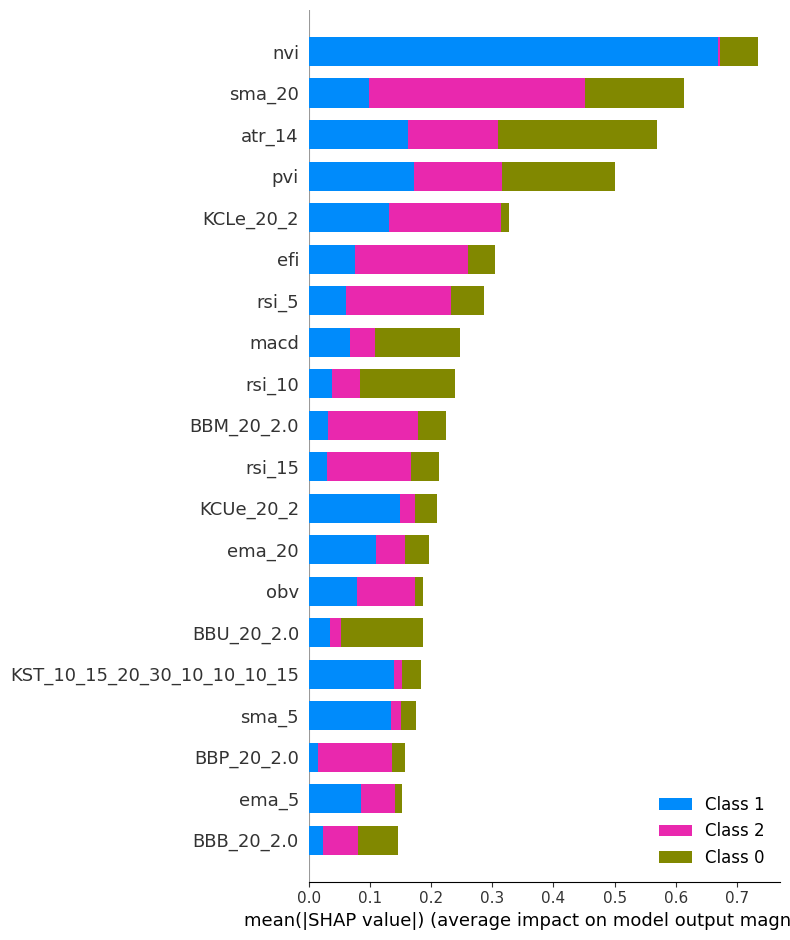

In [16]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")


In [17]:
val_df["predictions"] = best_model.predict(X_val)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10620\2697072571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["predictions"] = best_model.predict(X_val)


In [18]:
import plotly.graph_objs as go

def plot_signals(test_df, pred_column='predictions', start=0, length=100):
    """
    Plot OHLC candles from test_df with:
    • purple dots for model signals
    • EMA line
    """
    # Subset
    df_slice = test_df.iloc[start:start+length].copy()
    df_slice.reset_index(inplace=True)  # Reset for plotting

    # Candle plot
    fig = go.Figure(data=[go.Candlestick(
        x=df_slice['index'] if 'index' in df_slice else df_slice.index,
        open=df_slice['Open'],
        high=df_slice['High'],
        low=df_slice['Low'],
        close=df_slice['Close'],
        name='Candles'
    )])

    
    if 'ema' in df_slice.columns:                     # adjust column name if needed
        fig.add_trace(go.Scatter(
            x=df_slice['index'] if 'index' in df_slice else df_slice.index,
            y=df_slice['ema'],
            mode='lines',
            line=dict(width=1.5, dash='dot', color='orange'),
            name='EMA'
        ))
    

    # Bullish signals
    bull_idx = df_slice[df_slice[pred_column] == 2].index
    fig.add_trace(go.Scatter(
        x=df_slice.loc[bull_idx, 'index'] if 'index' in df_slice else bull_idx,
        y=df_slice.loc[bull_idx, 'Low'] - (df_slice['High']-df_slice['Low']).mean()*0.1,
        mode='markers',
        marker=dict(size=7, color='purple', symbol='circle'),
        name='Bullish signal (2)'
    ))

    # Bearish signals
    bear_idx = df_slice[df_slice[pred_column] == 1].index
    fig.add_trace(go.Scatter(
        x=df_slice.loc[bear_idx, 'index'] if 'index' in df_slice else bear_idx,
        y=df_slice.loc[bear_idx, 'High'] + (df_slice['High']-df_slice['Low']).mean()*0.1,
        mode='markers',
        marker=dict(size=7, color='purple', symbol='circle'),
        name='Bearish signal (1)'
    ))


    # Bullish labels
    bull_idx = df_slice[df_slice[best_label] == 2].index
    fig.add_trace(go.Scatter(
        x=df_slice.loc[bull_idx, 'index'] if 'index' in df_slice else bull_idx,
        y=df_slice.loc[bull_idx, 'Low'] - (df_slice['High']-df_slice['Low']).mean()*0.5,
        mode='markers',
        marker=dict(size=7, color='red', symbol='triangle-up'),
        name='Bullish Label (2)'
    ))

    # Bearish labels
    bear_idx = df_slice[df_slice[best_label] == 1].index
    fig.add_trace(go.Scatter(
        x=df_slice.loc[bear_idx, 'index'] if 'index' in df_slice else bear_idx,
        y=df_slice.loc[bear_idx, 'High'] + (df_slice['High']-df_slice['Low']).mean()*0.5,
        mode='markers',
        marker=dict(size=7, color='red', symbol='triangle-down'),
        name='Bearish Label (1)'
    ))

    fig.update_layout(
        title=f"Signals (purple) & EMA from index {start} to {start+length}",
        xaxis_title="Index",
        yaxis_title="Price",
        showlegend=True,
        height=600,
        width=1000
    )
    fig.show()


plot_signals(val_df, pred_column="sel_preds", start=0, length=160)


## 🧪 Experimental Section: Additional Analysis & Extensions

---

### ⚠️ Work in Progress

The code cells below contain **experimental features** and additional analysis components that are either:
- Under active development
- Left for future exploration
- Provided as starting points for extended analysis

### 📋 Contents Include:

| Component | Description |
|-----------|-------------|
| **Comprehensive Metrics** | Extended classification metrics including MCC, balanced accuracy |
| **Confusion Matrix** | Normalized heatmap visualization of prediction errors |
| **ROC Curves** | One-vs-Rest ROC analysis with AUC scores |
| **Walk-Forward Validation** | Rolling window backtesting approach |

### 🔬 Walk-Forward Validation

This is a more realistic simulation of how the model would be used in production:

```
Window 1: [Train: 2010-2015] → [Test: 2015-2016]
Window 2: [Train: 2010-2016] → [Test: 2016-2017]
Window 3: [Train: 2010-2017] → [Test: 2017-2018]
... and so on
```

Each window retrains the model with an expanding dataset, mimicking real-world periodic model updates.

### 📝 Notes

Feel free to modify, extend, or use these code snippets as a foundation for your own analysis. They demonstrate various evaluation techniques commonly used in quantitative finance.

In [19]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

y_pred   = best_model.predict(X_test)
y_proba  = best_model.predict_proba(X_test)

print("----- Classification report -----")
print(classification_report(y_test, y_pred, digits=4))

summary = {
    "Accuracy"          : accuracy_score(y_test, y_pred),
    "Balanced accuracy" : balanced_accuracy_score(y_test, y_pred),
    "Macro-F1"          : f1_score(y_test, y_pred, average="macro"),
    "Macro-Precision"   : precision_score(y_test, y_pred, average="macro"),
    "Macro-Recall"      : recall_score(y_test, y_pred, average="macro"),
    "MCC"               : matthews_corrcoef(y_test, y_pred)
}
pd.DataFrame(summary, index=["Score"]).T.style.format("{:.4f}")


----- Classification report -----
              precision    recall  f1-score   support

           0     0.7265    0.6273    0.6733       542
           1     0.1568    0.4592    0.2338        98
           2     0.6250    0.0763    0.1361       131

    accuracy                         0.5123       771
   macro avg     0.5028    0.3876    0.3477       771
weighted avg     0.6368    0.5123    0.5261       771



,Score
Accuracy,0.5123
Balanced accuracy,0.3876
Macro-F1,0.3477
Macro-Precision,0.5028
Macro-Recall,0.3876
MCC,0.0730


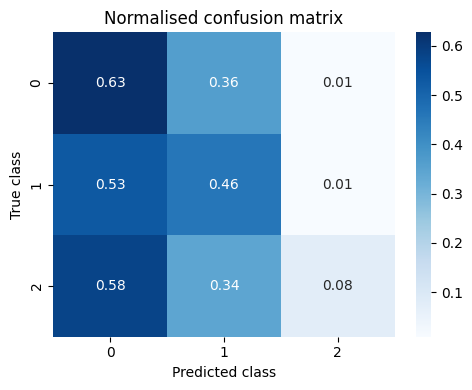

In [20]:
# Confusion-matrix heat-map (normalised row-wise)
cm  = confusion_matrix(y_test, y_pred, labels=[0,1,2])
cmn = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["0","1","2"], yticklabels=["0","1","2"])
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Normalised confusion matrix")
plt.tight_layout()
plt.show()


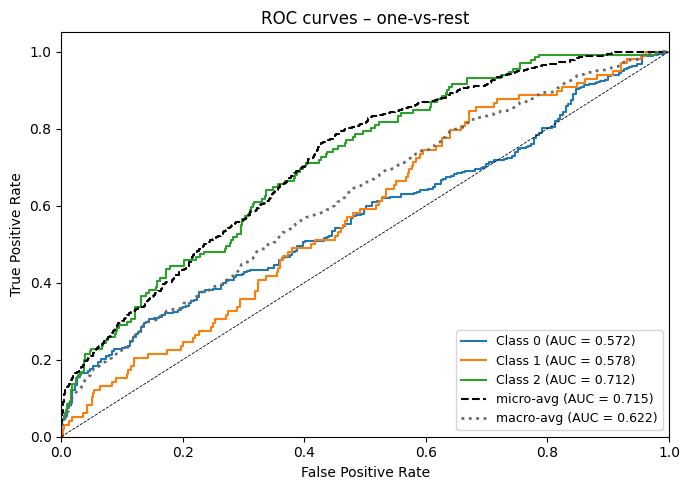

In [21]:
# ROC curves (one-vs-rest) + macro/micro averages
n_classes = 3
fpr = dict(); tpr = dict(); roc_auc = dict()

# one-vs-rest curves
for c in range(n_classes):
    fpr[c], tpr[c], _ = roc_curve((y_test == c).astype(int), y_proba[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(
    pd.get_dummies(y_test).values.ravel(), y_proba.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average (average the FPR points first, then AU-C)
all_fpr = np.unique(np.concatenate([fpr[c] for c in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for c in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ---------- Plot ----------
plt.figure(figsize=(7,5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # default matplotlib palette

for c, col in zip(range(n_classes), colors):
    plt.plot(fpr[c], tpr[c], color=col,
             label=f"Class {c} (AUC = {roc_auc[c]:.3f})", lw=1.5)

# macro & micro
plt.plot(fpr["micro"], tpr["micro"], linestyle="--", color="black",
         label=f"micro-avg (AUC = {roc_auc['micro']:.3f})", lw=1.5)
plt.plot(fpr["macro"], tpr["macro"], linestyle=":", color="dimgray",
         label=f"macro-avg (AUC = {roc_auc['macro']:.3f})", lw=2)

plt.plot([0,1], [0,1], "k--", lw=0.6)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves – one-vs-rest")
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()


In [22]:
print("\nArea-under-curve (AUC) scores:")
auc_tbl = pd.DataFrame(
    {f"Class {c}": roc_auc[c] for c in range(n_classes)} |
    {"micro-avg": roc_auc["micro"], "macro-avg": roc_auc["macro"]},
    index=["AUC"]
).T
auc_tbl.style.format("{:.4f}")



Area-under-curve (AUC) scores:


,AUC
Class 0,0.5723
Class 1,0.5782
Class 2,0.7119
micro-avg,0.7152
macro-avg,0.6221


In [23]:
# ==================================================
# Walk-Forward (Rolling window) Validation Approach
# ==================================================

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import pandas as pd

n_splits = 5  # change this for more/less rolling windows
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_metrics = []

print(f"\nWalk-forward validation ({n_splits} splits) on label: {best_label}\n")
for fold, (train_idx, test_idx) in enumerate(tscv.split(df_ta)):
    train = df_ta.iloc[train_idx]
    test = df_ta.iloc[test_idx]
    X_train, y_train = train[feature_cols], train[best_label]
    X_test, y_test = test[feature_cols], test[best_label]

    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=3,
        n_jobs=-1,
        eval_metric='mlogloss',
        seed=42,
        use_label_encoder=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = {
        "fold": fold+1,
        "start": test.index[0],
        "end": test.index[-1],
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "precision_macro": precision_score(y_test, y_pred, average="macro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
    }
    fold_metrics.append(metrics)
    print(f"Fold {fold+1}: {test.index[0]} to {test.index[-1]}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}, F1-macro: {metrics['f1_macro']:.4f}\n")

# summary DataFrame
results_df = pd.DataFrame(fold_metrics)
display(results_df)

print("\nMean (±std) metrics across folds:")
for m in ["accuracy", "f1_macro", "precision_macro", "recall_macro"]:
    print(f"{m:15}: {results_df[m].mean():.4f} ± {results_df[m].std():.4f}")



Walk-forward validation (5 splits) on label: label_la10_th0.020



f:\Python\Lib\site-packages\xgboost\training.py:183: UserWarning:

[19:38:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


f:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

f:\Python\Lib\site-packages\xgboost\training.py:183: UserWarning:

[19:38:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Fold 1: 2012-10-08 00:00:00 to 2015-04-29 00:00:00
  Accuracy: 0.7352, F1-macro: 0.3792



f:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

f:\Python\Lib\site-packages\xgboost\training.py:183: UserWarning:

[19:38:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Fold 2: 2015-04-30 00:00:00 to 2017-11-15 00:00:00
  Accuracy: 0.8551, F1-macro: 0.4237



f:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

f:\Python\Lib\site-packages\xgboost\training.py:183: UserWarning:

[19:38:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Fold 3: 2017-11-16 00:00:00 to 2020-06-08 00:00:00
  Accuracy: 0.7430, F1-macro: 0.3598

Fold 4: 2020-06-09 00:00:00 to 2022-12-22 00:00:00
  Accuracy: 0.1729, F1-macro: 0.1127



f:\Python\Lib\site-packages\xgboost\training.py:183: UserWarning:

[19:38:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Fold 5: 2022-12-23 00:00:00 to 2025-07-15 00:00:00
  Accuracy: 0.4548, F1-macro: 0.3079



,fold,start,end,accuracy,f1_macro,precision_macro,recall_macro
0,1,2012-10-08,2015-04-29,0.735202,0.379210,0.364852,0.424183
1,2,2015-04-30,2017-11-15,0.855140,0.423747,0.412132,0.436071
2,3,2017-11-16,2020-06-08,0.742991,0.359824,0.381223,0.378138
3,4,2020-06-09,2022-12-22,0.172897,0.112720,0.264992,0.342235
4,5,2022-12-23,2025-07-15,0.454829,0.307914,0.474581,0.463260



Mean (±std) metrics across folds:
accuracy       : 0.5922 ± 0.2770
f1_macro       : 0.3167 ± 0.1214
precision_macro: 0.3796 ± 0.0765
recall_macro   : 0.4088 ± 0.0483
